# Uncertainty sampling

In this notebook we can test the effectiveness of different uncertainty sampling methods on a toy dataset. <br>
Let's import the module:

In [1]:
import Sampler

And let's first create a toy dataset of 3 Gaussian blob clusters, with different centers and standard deviations to allow the classifier to have a good accuracy upper bound, but still similar enough that the decision boundaries aren't too obvious.<br>
We can initialize the classifier as Logistic Regression and the informativeness measure as least confidence, i.e., the simplest methods.
<br><br>
We also set the `train_size` and `first_samples_size` hyperparameters. The former is the total number of samples used to train the classifier both in random and uncertainty sampling, while the latter is the number of samples used to pre-train the classifier in uncertainty sampling. The pre-trained classifier will then rank the pool of unlabeled samples according to the informativeness measure we specified:

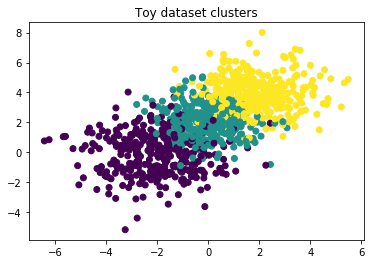

In [2]:
sampler = Sampler.Sampler(classifier='LR', cluster_type='blobs', informativeness_measure='least_confidence',
                          train_size=20, clusters_std=[1.4, 1, 1.2], centers=([-2, 0], [0, 2], [2, 4]),
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()
sampler.plot_initial_data(X, y)

Now that we have created our dataset, we can test the effectiveness of uncertainty sampling vs random sampling:

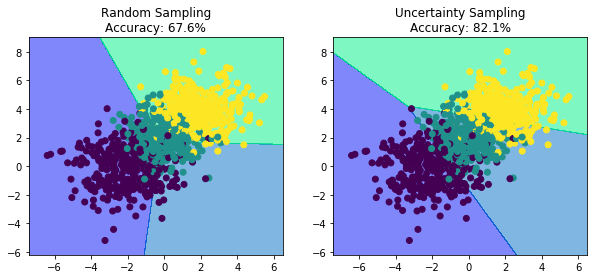

In [3]:
rs_score, us_score = sampler(X, y)

We can see that, in this case, uncertainty sampling did in fact perform better than random sampling. Let's try to use the *margin* informativeness measure instead of *least confidence*:

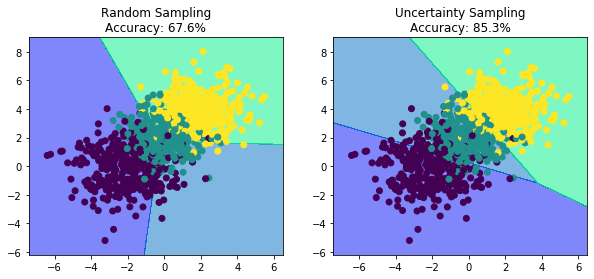

In [4]:
sampler = Sampler.Sampler(classifier='LR', cluster_type='blobs', informativeness_measure='margin',
                          train_size=20, clusters_std=[1.4, 1, 1.2], centers=([-2, 0], [0, 2], [2, 4]),
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()
rs_score, us_score = sampler(X, y)

The margin informativeness measure allowed the classifier to achieve higher accuracy. Let's see what happens with the *entropy* informativeness measure:

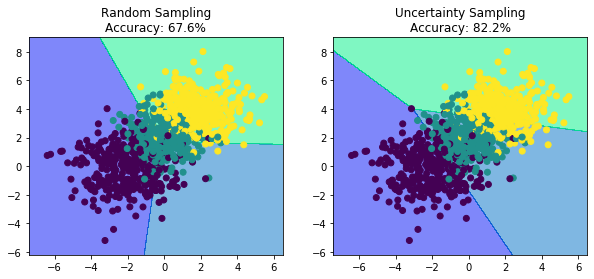

In [5]:
sampler = Sampler.Sampler(classifier='LR', cluster_type='blobs', informativeness_measure='entropy',
                          train_size=20, clusters_std=[1.4, 1, 1.2], centers=([-2, 0], [0, 2], [2, 4]),
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()
rs_score, us_score = sampler(X, y)

Entropy performed better than random sampling as well. But is this a consistent result, or due to how the dataset is split? Let's plot a learning curve for the same parameters and see if there is a consistent improvement in performance with active learning over random sampling. <br><br>
We set the sample size to $10000$. `train_size_ratio` determines the percentage fraction of data to use for training at each step. If set to $100$, the classifier will be trained on $1\%$ increments of the data. `n_attempts` determines the number of training steps. If set to $100$, and `train_size_ratio` is also set to $100$, the classifier will be trained $100$ times from $1\%$ to $100\%$ of the training data. `first_samples_ratio` determines the $1/k$ part of the training data the classifier is pre-trained on in active learning. If set to $2$, the classifier will be pre-trained on $1/2$ of the data at each iteration.

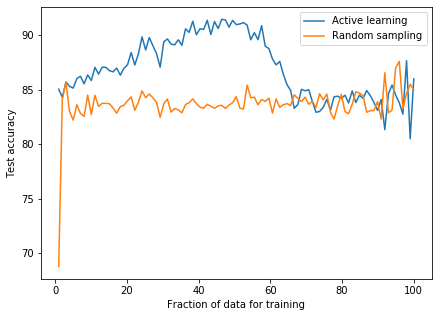

In [6]:
from Sampler import plot_learning_curve

plot_learning_curve(sample_size=10000, train_size_ratio=100, first_samples_ratio=2, n_attempts=100,
                   classifier='LR', cluster_type='blobs', informativeness_measure='least_confidence',
                   centers=([-2, 0], [0, 2], [2, 4]), clusters_std=[1.4, 1, 1.2])

We can see that, up to approximately $65\%$ of the training data, active learning performs better than random sampling. Let's try with a slightly more complex situation. <br><br>
If we work with moons (or circles), we can only generate two clusters. This task is therefore restricted to binary classification, and to the least confidence informativeness measure.

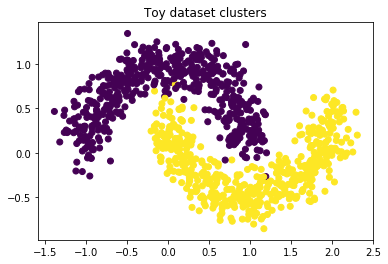

In [7]:
sampler = Sampler.Sampler(classifier='SVM', cluster_type='moons', informativeness_measure='least_confidence',
                          train_size=20, noise=.15,
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()
sampler.plot_initial_data(X, y)

With an SVM classifier:

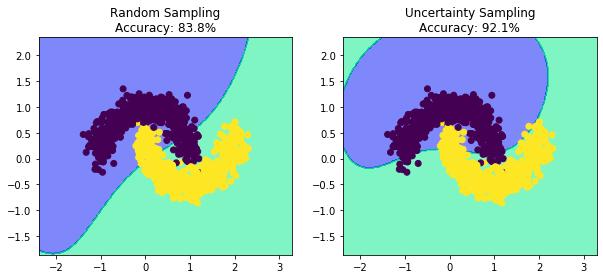

In [8]:
rs_score, us_score = sampler(X, y)

With a Logistic Regression classifier:

In [9]:
sampler = Sampler.Sampler(classifier='LR', cluster_type='moons', informativeness_measure='least_confidence',
                          train_size=20, noise=.15,
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()

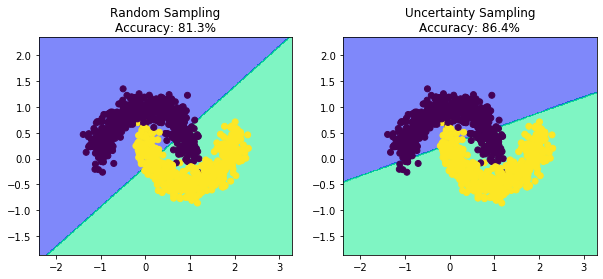

In [10]:
rs_score, us_score = sampler(X, y)

We can see that active learning tends to yield higher accuracy both with SVM and Logistic Regression. Let's look at the learning curve with the same parameters as before, for the SVM:

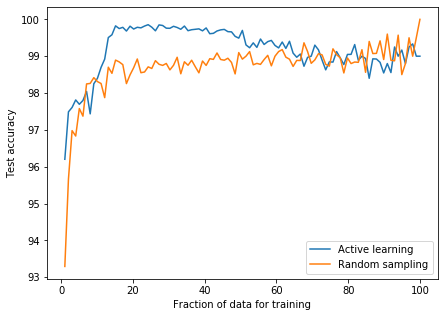

In [11]:
plot_learning_curve(sample_size=10000, train_size_ratio=100, first_samples_ratio=2, n_attempts=100,
                   classifier='SVM', cluster_type='moons', informativeness_measure='least_confidence',
                   noise=.15)

Let's see what happens with circle-shaped clusters:

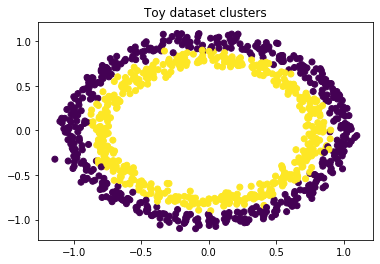

In [12]:
sampler = Sampler.Sampler(classifier='SVM', cluster_type='circles', informativeness_measure='least_confidence',
                          train_size=20, noise=.05,
                          first_samples_size=10, plot=True)
X, y = sampler.generate_data()
sampler.plot_initial_data(X, y)

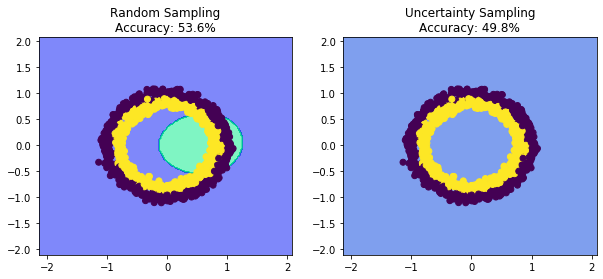

In [13]:
rs_score, us_score = sampler(X, y)

In this case, we can see that both classifiers have failed to create a correct decision boundary for the chosen amount of training samples, with the active learning classifier yielding a majority-class classification. <br><br>
Let's train the classifiers on more samples:

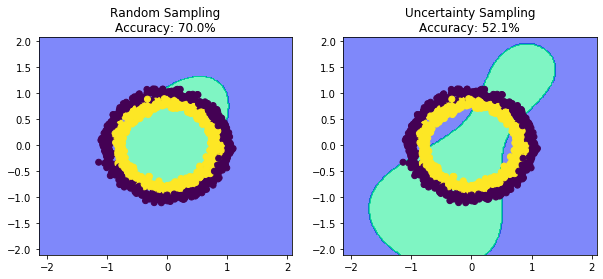

In [14]:
sampler = Sampler.Sampler(classifier='SVM', cluster_type='circles', informativeness_measure='least_confidence',
                          train_size=50, noise=.05,
                          first_samples_size=20, plot=True)
X, y = sampler.generate_data()
rs_score, us_score = sampler(X, y)

With a higher amount of training samples, we can see random sampling yield a considerably higher accuracy than uncertainty sampling. Let's see if this result is consistent by plotting the learning curve:

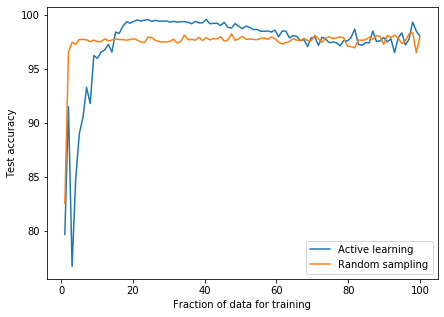

In [15]:
plot_learning_curve(sample_size=10000, train_size_ratio=100, first_samples_ratio=2, n_attempts=100,
                   classifier='SVM', cluster_type='circles', informativeness_measure='least_confidence',
                   noise=.05)

The active learning classifier is quite unstable in the early phases of the training, which might be due to the strong dependence of the performance on the quality of the samples picked for pre-training. Throughout the central iterations, however, active learning yields a better accuracy. 